# Analysis of time series and integration

In [33]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f''
file_prefix = f'rk5'
outdir = 'helvetios-runs/'

n_int_steps = 5
nnodes = 10  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 10 nodes.


In [35]:
mydata = pd.read_csv(f'model_output/FR-U-R1-T1.5-opt10.csv', index_col= 'date', parse_dates=True)
mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]
mydata[mydata['value']<0]

,comp,place,value,placeID,valuepop
date,,,,,
2021-01-02,V,Vercelli,-5.430383e-09,1,-3.177335e-14
2021-01-03,V,Vercelli,-1.031366e-08,1,-6.034557e-14
2021-01-04,V,Vercelli,-1.457021e-08,1,-8.525078e-14
2021-01-05,V,Vercelli,-1.808167e-08,1,-1.057964e-13
2021-01-06,V,Vercelli,-2.068776e-08,1,-1.210448e-13
...,...,...,...,...,...
2021-02-02,V,Genova,-9.657021e-08,9,-1.148033e-13
2021-02-03,V,Genova,-8.002825e-08,9,-9.513808e-14
2021-02-04,V,Genova,-6.027621e-08,9,-7.165673e-14


In [36]:
myopt = None

In [ ]:
myopt = pd.read_csv('model_output/20201129-opt107-r4000-m15000000.0.csv', index_col= 'date', parse_dates=True, )

# Comparisons with matlab integration

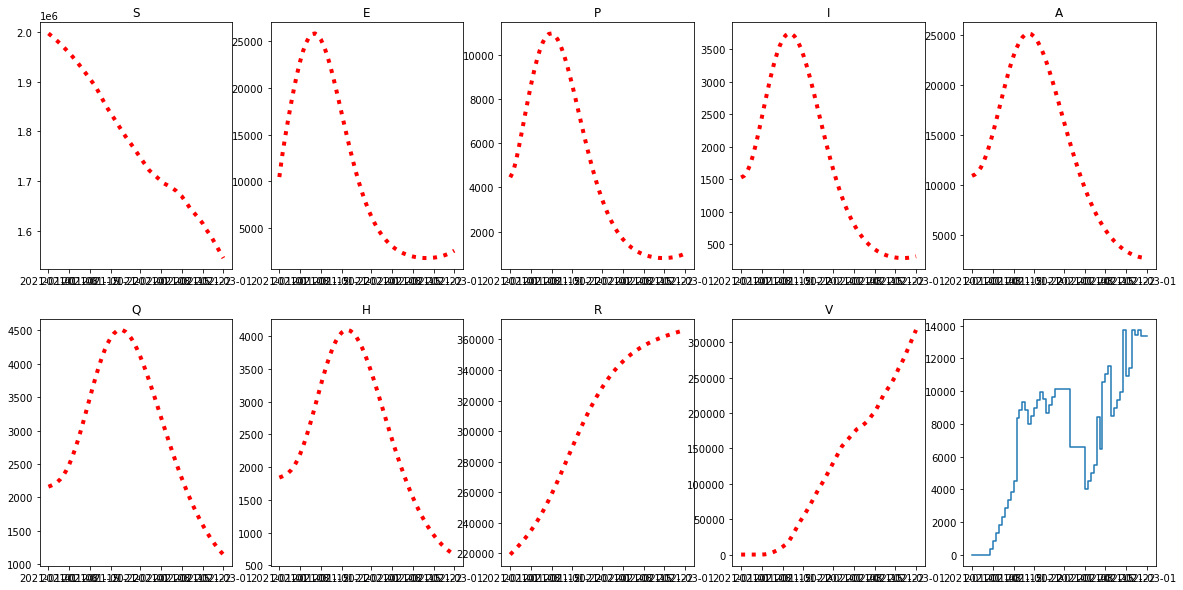

In [37]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

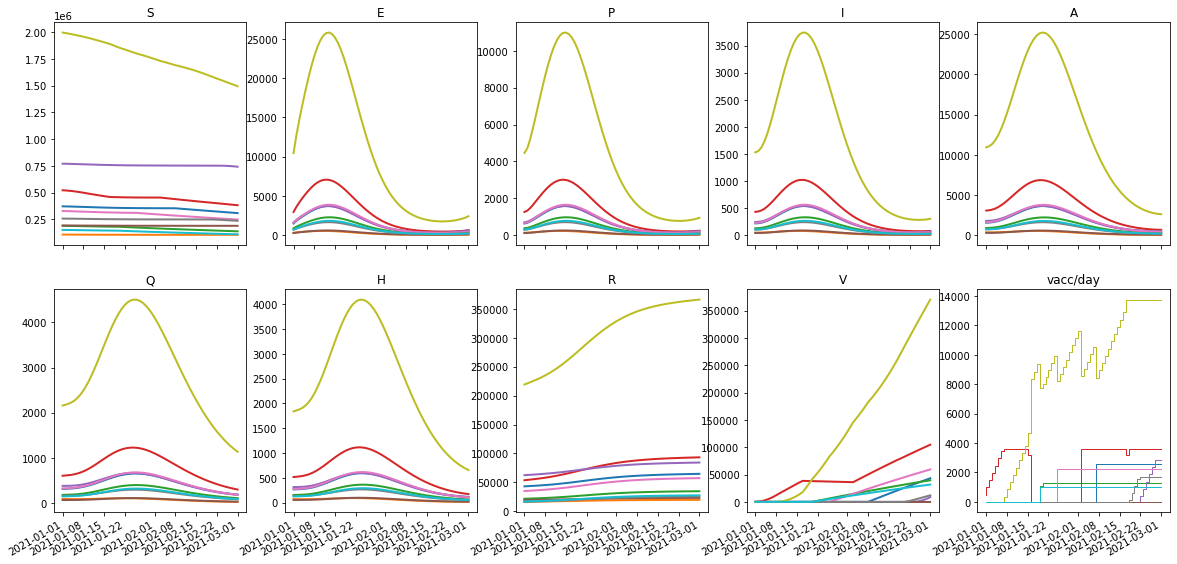

In [30]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

In [19]:
len(setup.pop_node[mydata['placeID']])

96300

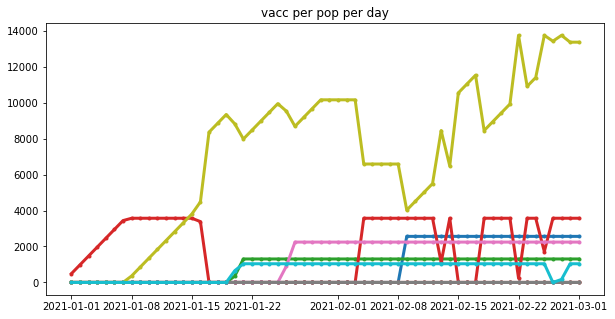

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '-', marker='.')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');


<AxesSubplot:xlabel='date'>

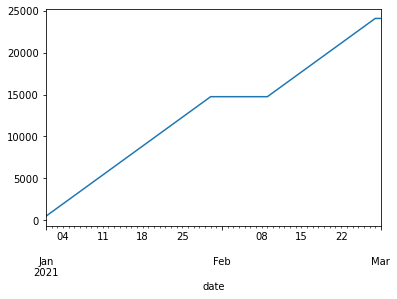

In [39]:
mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).plot()

I


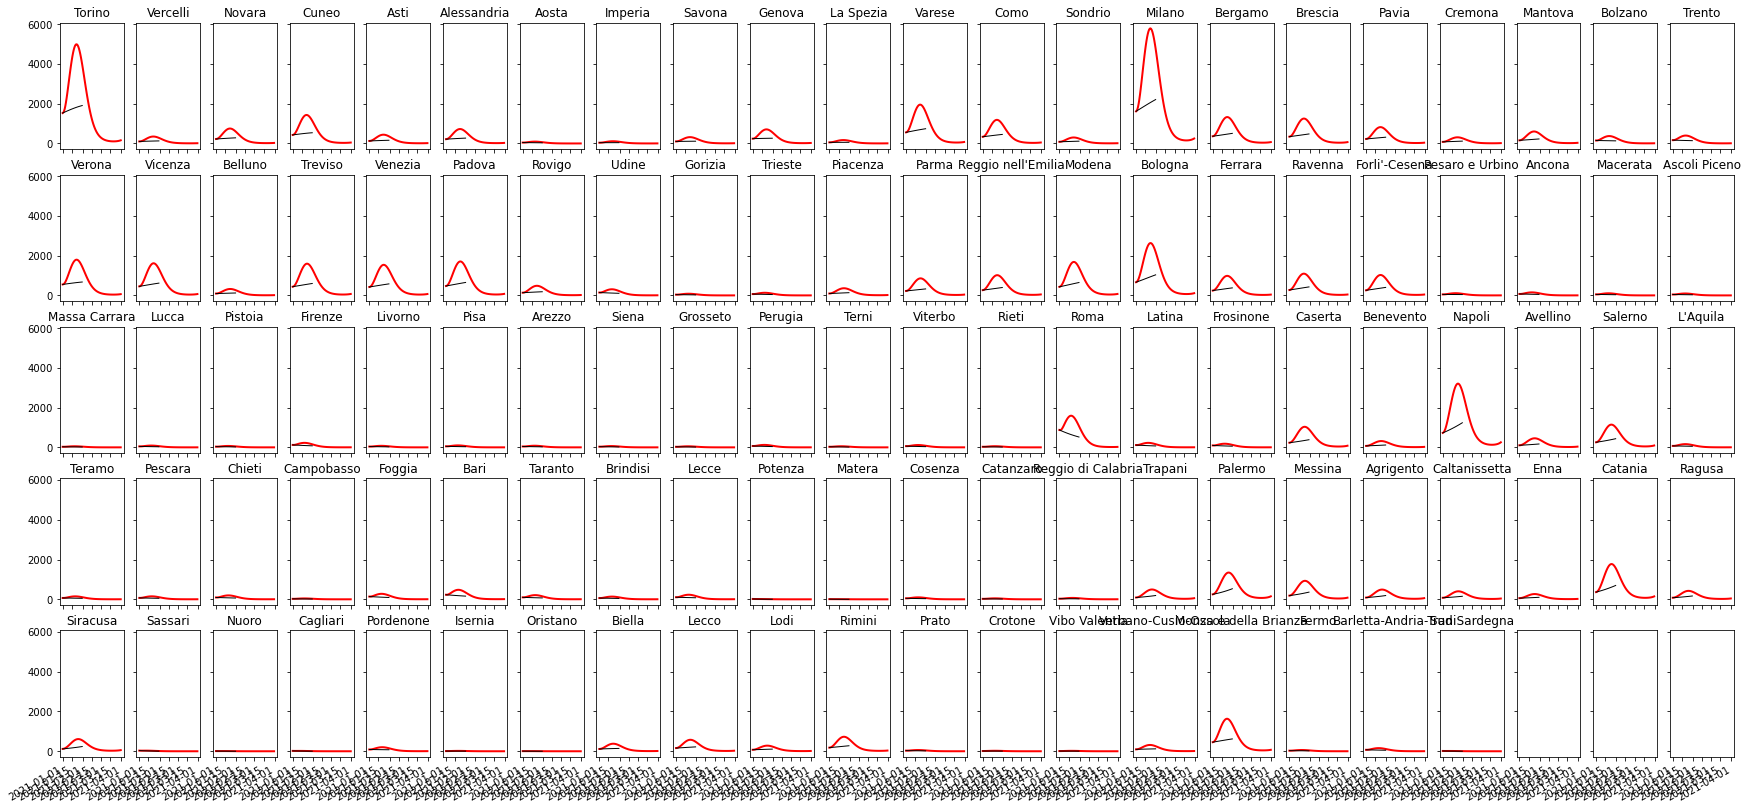

In [7]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()

# Compare scenarios

In [149]:
scenarios = [ 'U', 'L'] # 'U', 'C' 
mydata = {}
for scn in scenarios:
    mydata[scn] = pd.read_csv(f'model_output/FR-{scn}-R1-T10-int107-nc.csv', index_col= 'date', parse_dates=True)

I


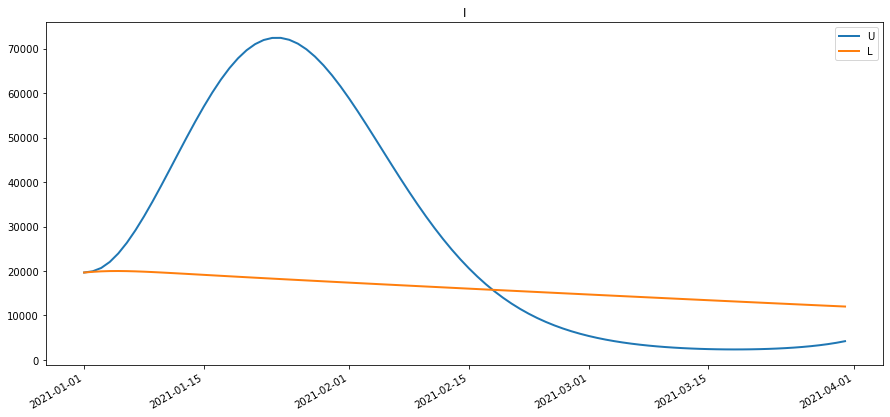

In [150]:
fig, axes = plt.subplots(1,1, figsize = (15,7), facecolor = 'white')
i = 3
st = states_names[i]
print(st)

for scn in scenarios:
    md = mydata[scn]
    axes.plot(md[(md['comp'] == st)].groupby('date').sum()['value'], linestyle='-', lw = 2, label = scn)
axes.set_title(st)
    
axes.legend()
fig.autofmt_xdate()

In [108]:
md[(md['comp'] == st)].groupby('date').sum()['value']

date
2021-01-01    19658.976218
2021-01-02    19822.602141
2021-01-03    19990.939663
2021-01-04    20161.552435
2021-01-05    20330.239115
                  ...     
2021-03-27    10993.040393
2021-03-28    10994.675066
2021-03-29    11005.178723
2021-03-30    11024.796018
2021-03-31    11053.792962
Name: value, Length: 90, dtype: float64

I


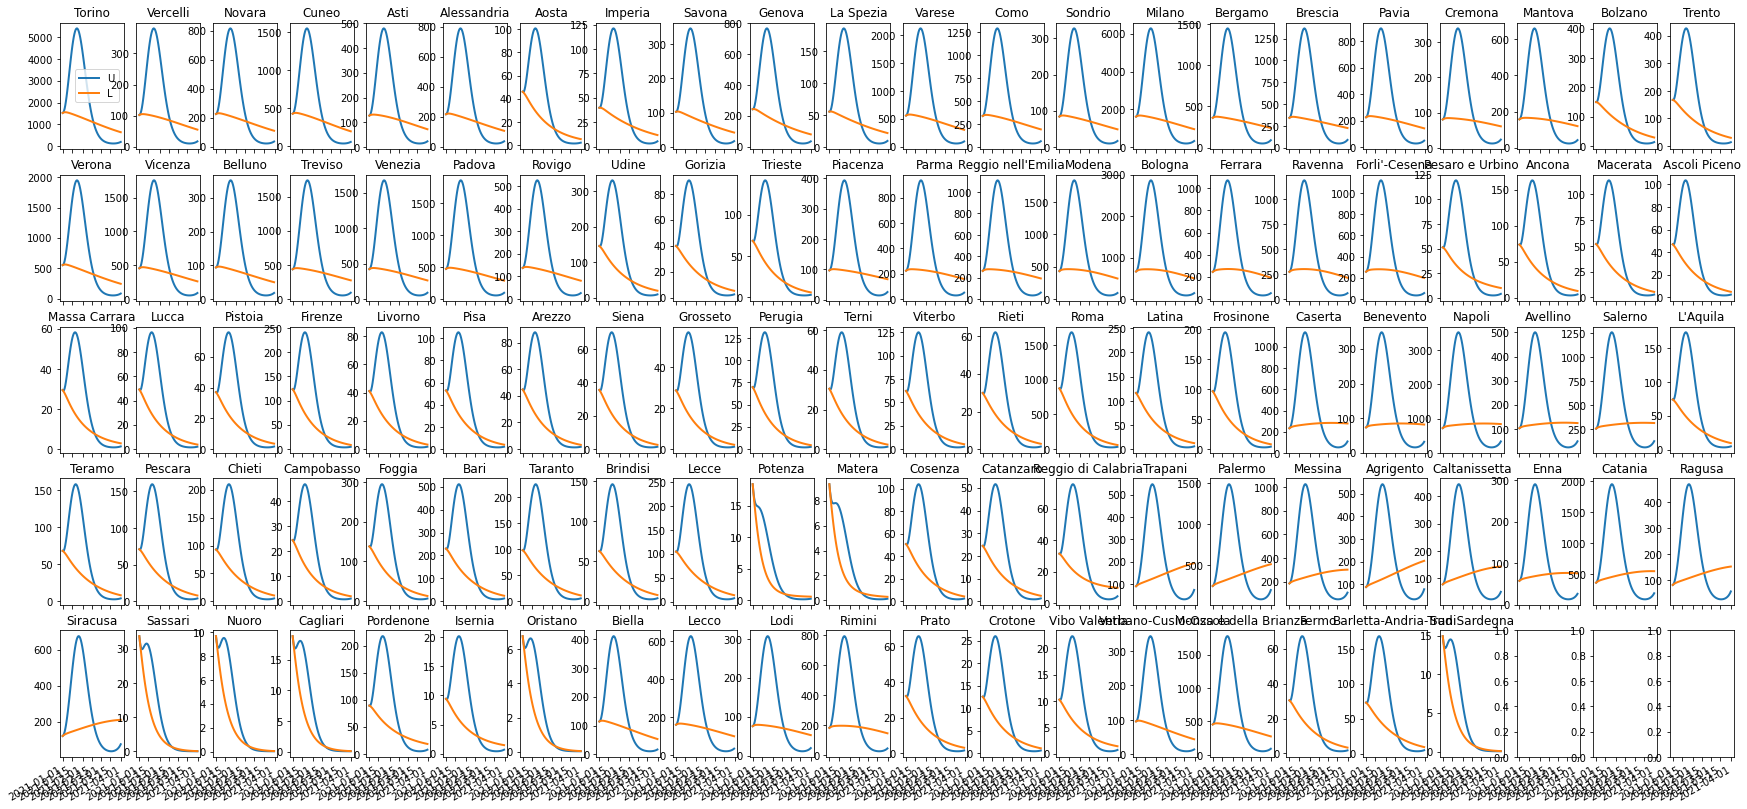

In [151]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white')#, sharey=True)
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    for scn in scenarios:
        md = mydata[scn]
        axes.flat[k].plot(md[(md['comp'] == st) & (md['placeID'] == k)]['value'], linestyle='-', lw = 2, label = scn)
    axes.flat[k].set_title(nname)
    
axes.flat[0].legend()
fig.autofmt_xdate()